In [ ]:
!pip install gdown

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import gdown

file_id = "1C2KWjdEcwdbhUGRyh0-kb4Mg2s-morSB"
destination = "/content/Crema.zip"
gdown.download(f"https://drive.google.com/uc?export=download&id={file_id}", destination, quiet=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1C2KWjdEcwdbhUGRyh0-kb4Mg2s-morSB
From (redirected): https://drive.google.com/uc?export=download&id=1C2KWjdEcwdbhUGRyh0-kb4Mg2s-morSB&confirm=t&uuid=9fa2b753-9771-4f4d-a15c-7b20c034b4dc
To: /content/Crema.zip
100%|██████████| 473M/473M [00:12<00:00, 38.9MB/s]


'/content/Crema.zip'

In [ ]:
import zipfile
import os

zip_file_path = destination
extraction_dir = 'crema_file/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

extracted_files = os.listdir(extraction_dir)
extracted_files


In [ ]:
import librosa
import numpy as np
import pandas as pd

def extract_features(file_path, n_mfcc=40):
    # Load the audio file
    audio, sample_rate = librosa.load(file_path)

    # Extract MFCC features
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)

    # Compute the mean of the MFCCs features
    mfccs_mean = np.mean(mfccs.T, axis=0)

    return mfccs_mean

# Create a DataFrame to hold the features and labels
features_list = []
labels_list = []

# Define the emotions we expect in the dataset
emotions = {
    'ANG': 'angry',
    'DIS': 'disgust',
    'FEA': 'fear',
    'HAP': 'happy',
    'NEU': 'neutral',
    'SAD': 'sad'
}

# Extract features from each file and store them along with the corresponding label
for file in extracted_files:
    if file.endswith('.wav'):
        file_path = os.path.join(extraction_dir, file)
        emotion_code = file.split('_')[2]
        if emotion_code in emotions:
            features = extract_features(file_path)
            features_list.append(features)
            labels_list.append(emotions[emotion_code])

# Create a DataFrame with features and labels
features_df = pd.DataFrame(features_list)
features_df['label'] = labels_list

# Display the first few rows of the DataFrame
features_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,label
0,-341.988922,120.799965,-9.834449,39.606232,-2.239531,13.864772,-18.852041,-2.982337,-11.125525,-2.109577,-11.664308,-1.972009,-3.127181,-14.003941,8.412565,-13.201678,-6.435089,-4.521847,-1.478821,-9.107391,-5.787456,-5.252784,-8.013854,-2.199342,-5.206577,2.173044,-5.476537,-0.499655,-2.827035,-1.377905,-1.804183,-1.959378,-0.245551,-3.706382,-3.278785,-6.545132,-2.730202,-5.091173,-1.669949,-3.697248,angry
1,-388.461945,133.882111,-17.753075,53.109615,-0.516854,22.838816,-23.992502,7.696455,-11.807549,-1.607505,-9.029036,-5.325351,-0.126413,-14.173067,5.774044,-16.827906,-1.730270,-6.018618,-1.303163,-9.669220,-6.488826,-1.773448,-7.261394,-3.807744,-6.332784,5.345534,-7.167720,0.918267,-2.781765,-0.831845,-0.334464,-1.620630,0.955743,-3.576290,-0.874058,-7.539760,-0.422784,-3.736739,-0.197444,-2.462972,disgust
2,-352.208435,115.791069,-3.415168,32.881832,5.439893,11.282278,-16.918011,-0.038774,-7.281857,-3.811908,-12.299890,-4.942386,-3.586811,-11.700261,2.681639,-12.057004,-5.221643,-6.181847,-3.350925,-8.541812,-6.988221,-4.781175,-6.455094,-5.374062,-7.563201,-0.635579,-7.306174,-2.503201,-2.114250,1.855911,1.639125,-0.682668,1.528331,1.340156,1.897146,-1.497766,0.001429,-3.316483,0.384523,-2.383146,fear
3,-337.839569,120.109604,-12.691747,39.687588,4.412653,10.073730,-21.633324,0.222240,-10.304431,-6.165375,-14.998136,-2.926191,-2.536832,-15.856325,5.049293,-12.914876,-5.717532,-5.490536,-2.052112,-8.918370,-5.248331,-2.202410,-5.715617,-2.472631,-8.225609,0.522852,-6.821119,-4.406751,-3.581703,-1.135412,-2.653944,-2.803949,0.707733,-1.757593,0.153938,-3.118739,-0.232440,-1.459717,2.867212,0.115858,happy
4,-368.175568,124.364937,-4.643918,39.390564,6.951158,12.446601,-13.139218,-2.361498,-10.503442,-4.843660,-10.041851,-0.964123,-3.805397,-10.458350,7.129698,-12.505527,-4.903613,-5.511658,-2.632820,-5.688359,-7.074147,-4.105097,-3.802071,-4.337938,-7.706544,3.580925,-4.500918,-1.941922,-0.436765,0.753447,-0.581217,-3.939406,-1.073810,-1.127420,-0.477086,-4.165790,-1.477617,-3.486347,0.347069,-1.620177,neutral


In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape, Input, Resizing
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Function to extract features from an audio file
def extract_features(file_path, n_mfcc=40):
    audio, sample_rate = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    return mfccs_mean

# Create a DataFrame to hold the features and labels
features_list = []
labels_list = []

# Define the emotions we expect in the dataset
emotions = {
    'ANG': 'angry',
    'DIS': 'disgust',
    'FEA': 'fear',
    'HAP': 'happy',
    'NEU': 'neutral',
    'SAD': 'sad'
}

# Extract features from each file and store them along with the corresponding label
for file in extracted_files:
    if file.endswith('.wav'):
        file_path = os.path.join(extraction_dir, file)
        emotion_code = file.split('_')[2]
        if emotion_code in emotions:
            features = extract_features(file_path)
            features_list.append(features)
            labels_list.append(emotions[emotion_code])

# Create a DataFrame with features and labels
features_df = pd.DataFrame(features_list)
features_df['label'] = labels_list

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(features_df['label'])
y_one_hot = to_categorical(y_encoded)

# Standardize the features
X = StandardScaler().fit_transform(features_df.drop(['label'], axis=1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.3, random_state=42)

# Reshape the data for the CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

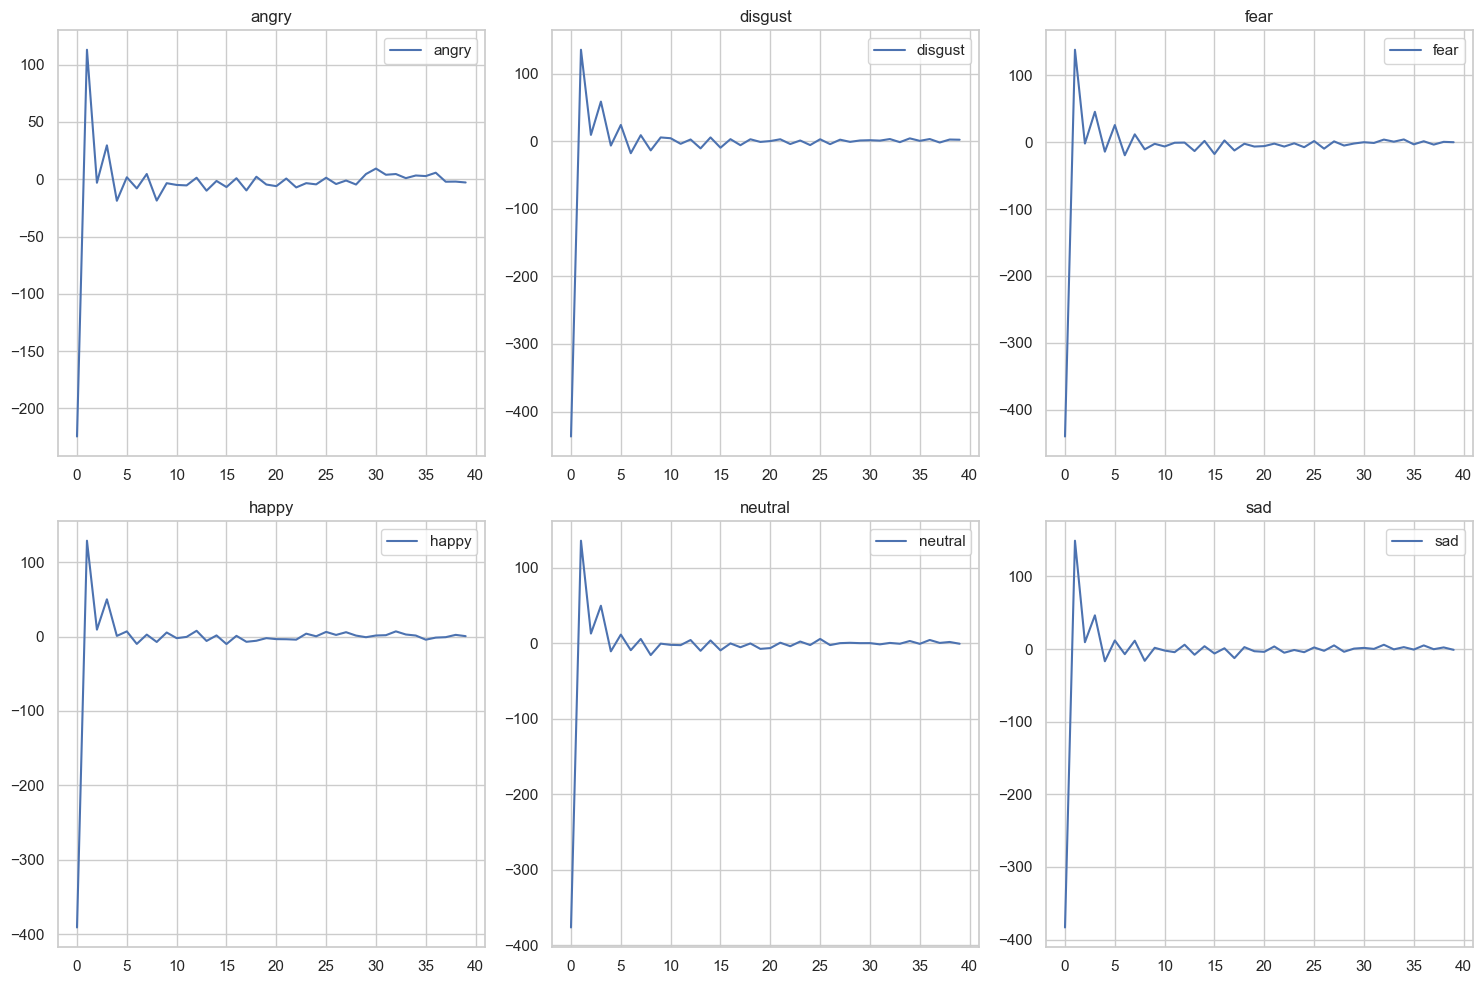

In [ ]:
plt.figure(figsize=(15, 10))
for i, emotion in enumerate(emotions.values()):
    plt.subplot(2, 3, i + 1)
    plt.title(emotion)
    idx = y_encoded == i
    sample_idx = np.random.choice(np.where(idx)[0], 1)  # Select one random sample for each label
    plt.plot(features_df.loc[sample_idx, :].drop('label', axis=1).values.flatten(), label=emotion)
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Define the CNN model
model = Sequential([
    Input(shape=(40, 1)),
    Reshape((40, 1, 1)),  # Add channel dimension
    Resizing(32, 32),
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(y_train.shape[1], activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test),callbacks=[lr_reduction])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')


Epoch 1/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.3145 - loss: 1.6271 - val_accuracy: 0.4062 - val_loss: 1.4631 - learning_rate: 0.0010
Epoch 2/150
 11/163 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4070 - loss: 1.4852

c:\Python310\lib\site-packages\keras\src\callbacks\callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3939 - loss: 1.4505 - val_accuracy: 0.4196 - val_loss: 1.4153 - learning_rate: 0.0010
Epoch 3/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4212 - loss: 1.3901 - val_accuracy: 0.4532 - val_loss: 1.3727 - learning_rate: 0.0010
Epoch 4/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4421 - loss: 1.3649 - val_accuracy: 0.4514 - val_loss: 1.3887 - learning_rate: 0.0010
Epoch 5/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4583 - loss: 1.3197 - val_accuracy: 0.4398 - val_loss: 1.3817 - learning_rate: 0.0010
Epoch 6/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4566 - loss: 1.3043 - val_accuracy: 0.4554 - val_loss: 1.3574 - learning_rate: 0.0010
Epoch 7/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5059 - loss: 1.2438 - val_accuracy: 0.4563 - val_loss: 1.3730 - learning_rate: 0.0010
Epoch 8/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5134 - loss: 1.2155 

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Confusion Matrix:
[[220  26  21  79  10   3]
 [ 44 112  41  60  59  70]
 [ 29  46 116  70  39  71]
 [ 68  44  60 139  51  16]
 [ 12  47  48  50 128  68]
 [  3  44  80  14  55 190]]


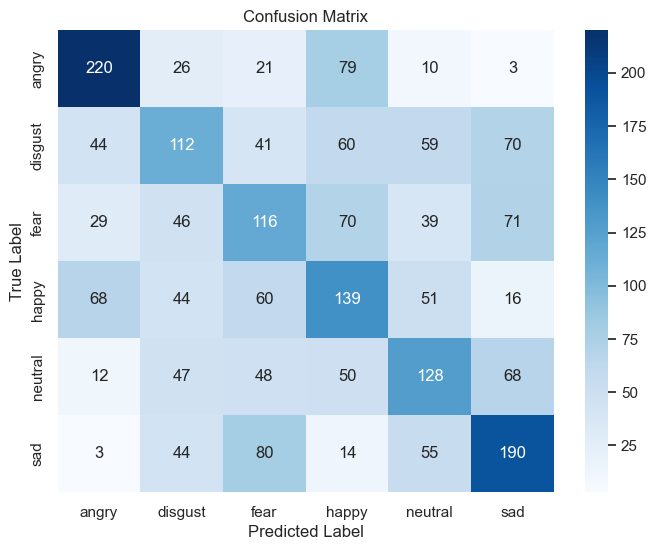

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Predict classes on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
class_names = label_encoder.classes_
print(classification_report(y_true, y_pred_classes, target_names=class_names))


              precision    recall  f1-score   support

       angry       0.59      0.61      0.60       359
     disgust       0.35      0.29      0.32       386
        fear       0.32      0.31      0.31       371
       happy       0.34      0.37      0.35       378
     neutral       0.37      0.36      0.37       353
         sad       0.45      0.49      0.47       386

    accuracy                           0.41      2233
   macro avg       0.40      0.41      0.40      2233
weighted avg       0.40      0.41      0.40      2233



In [ ]:
model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_8 (Reshape)             │ (None, 40, 1, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_8 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,439,860 (9.31 MB)

 Trainable params: 813,286 (3.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,626,574 (6.20 MB)

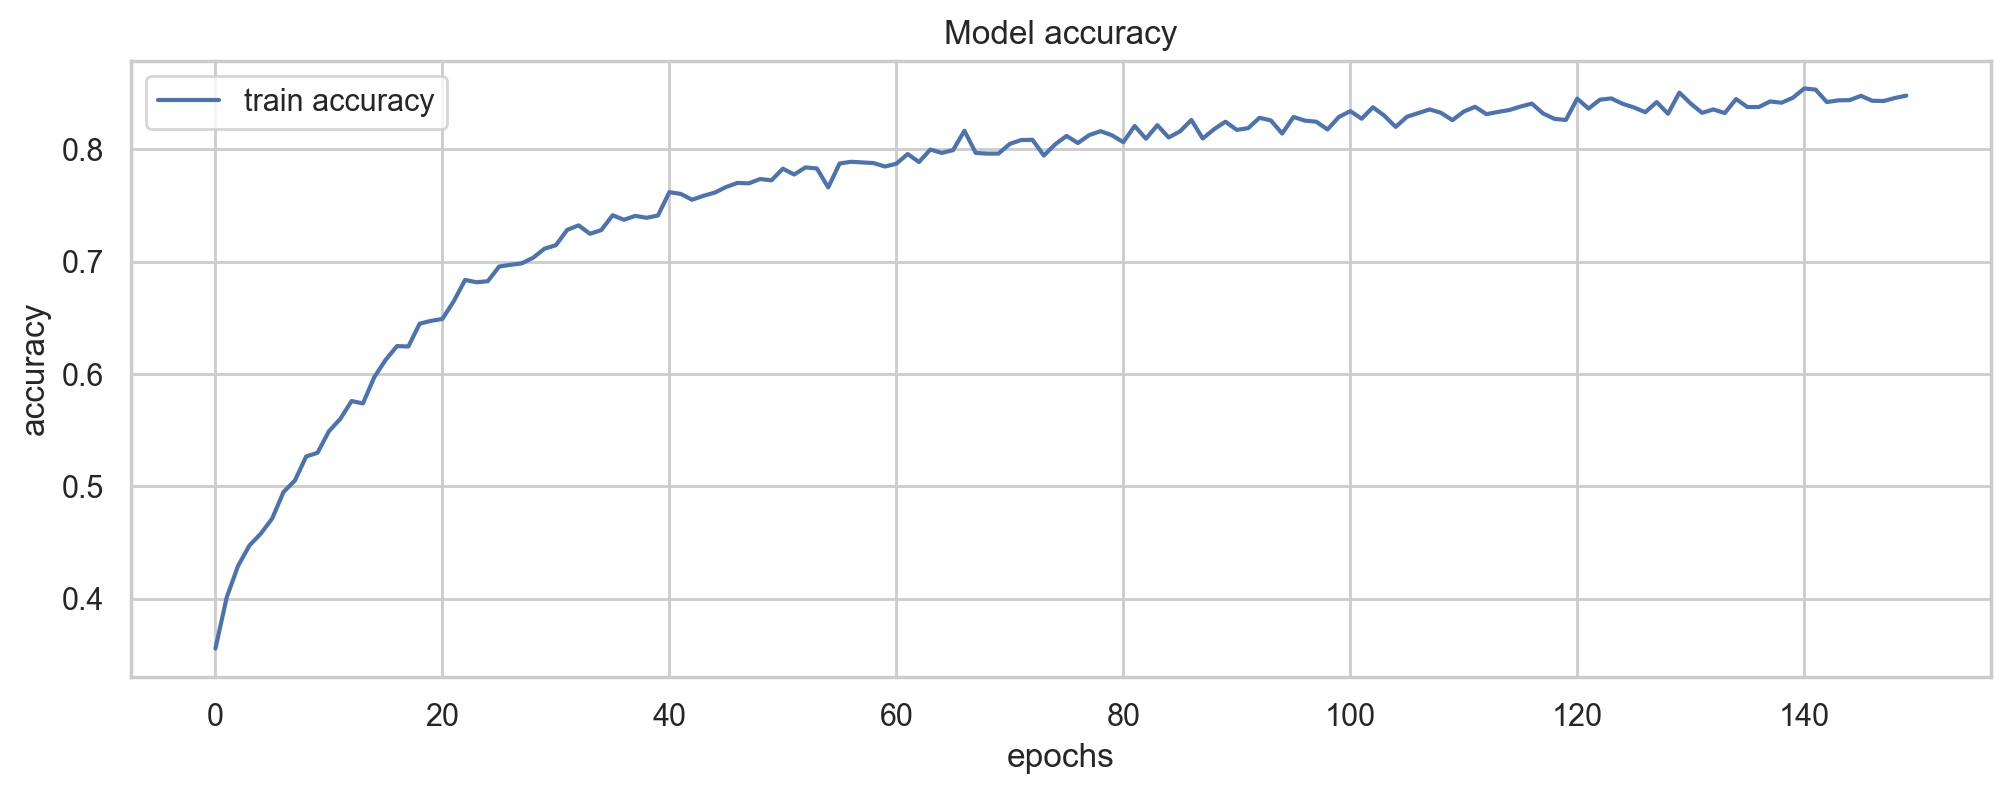

In [ ]:
import matplotlib.pyplot as plt
epochs = list(range(150))
acc = history.history['accuracy']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(epochs, acc, label='train accuracy', color='b')
plt.title('Model accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

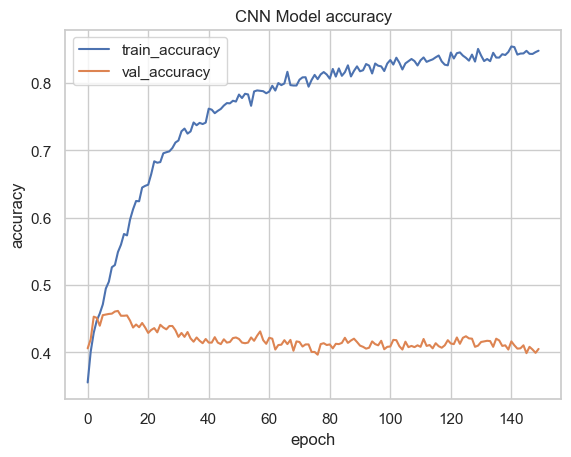

In [ ]:
plt. plot (history. history['accuracy'])
plt. plot(history.history[ 'val_accuracy'])
plt. title( 'CNN Model accuracy')
plt. ylabel( 'accuracy')
plt. xlabel( 'epoch')
plt. legend(['train_accuracy', 'val_accuracy'])
plt. show()

C:\Users\yonat\AppData\Local\Temp\ipykernel_10204\3804164615.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x= Count_emotion, y= Count_emotion.index, palette="mako")


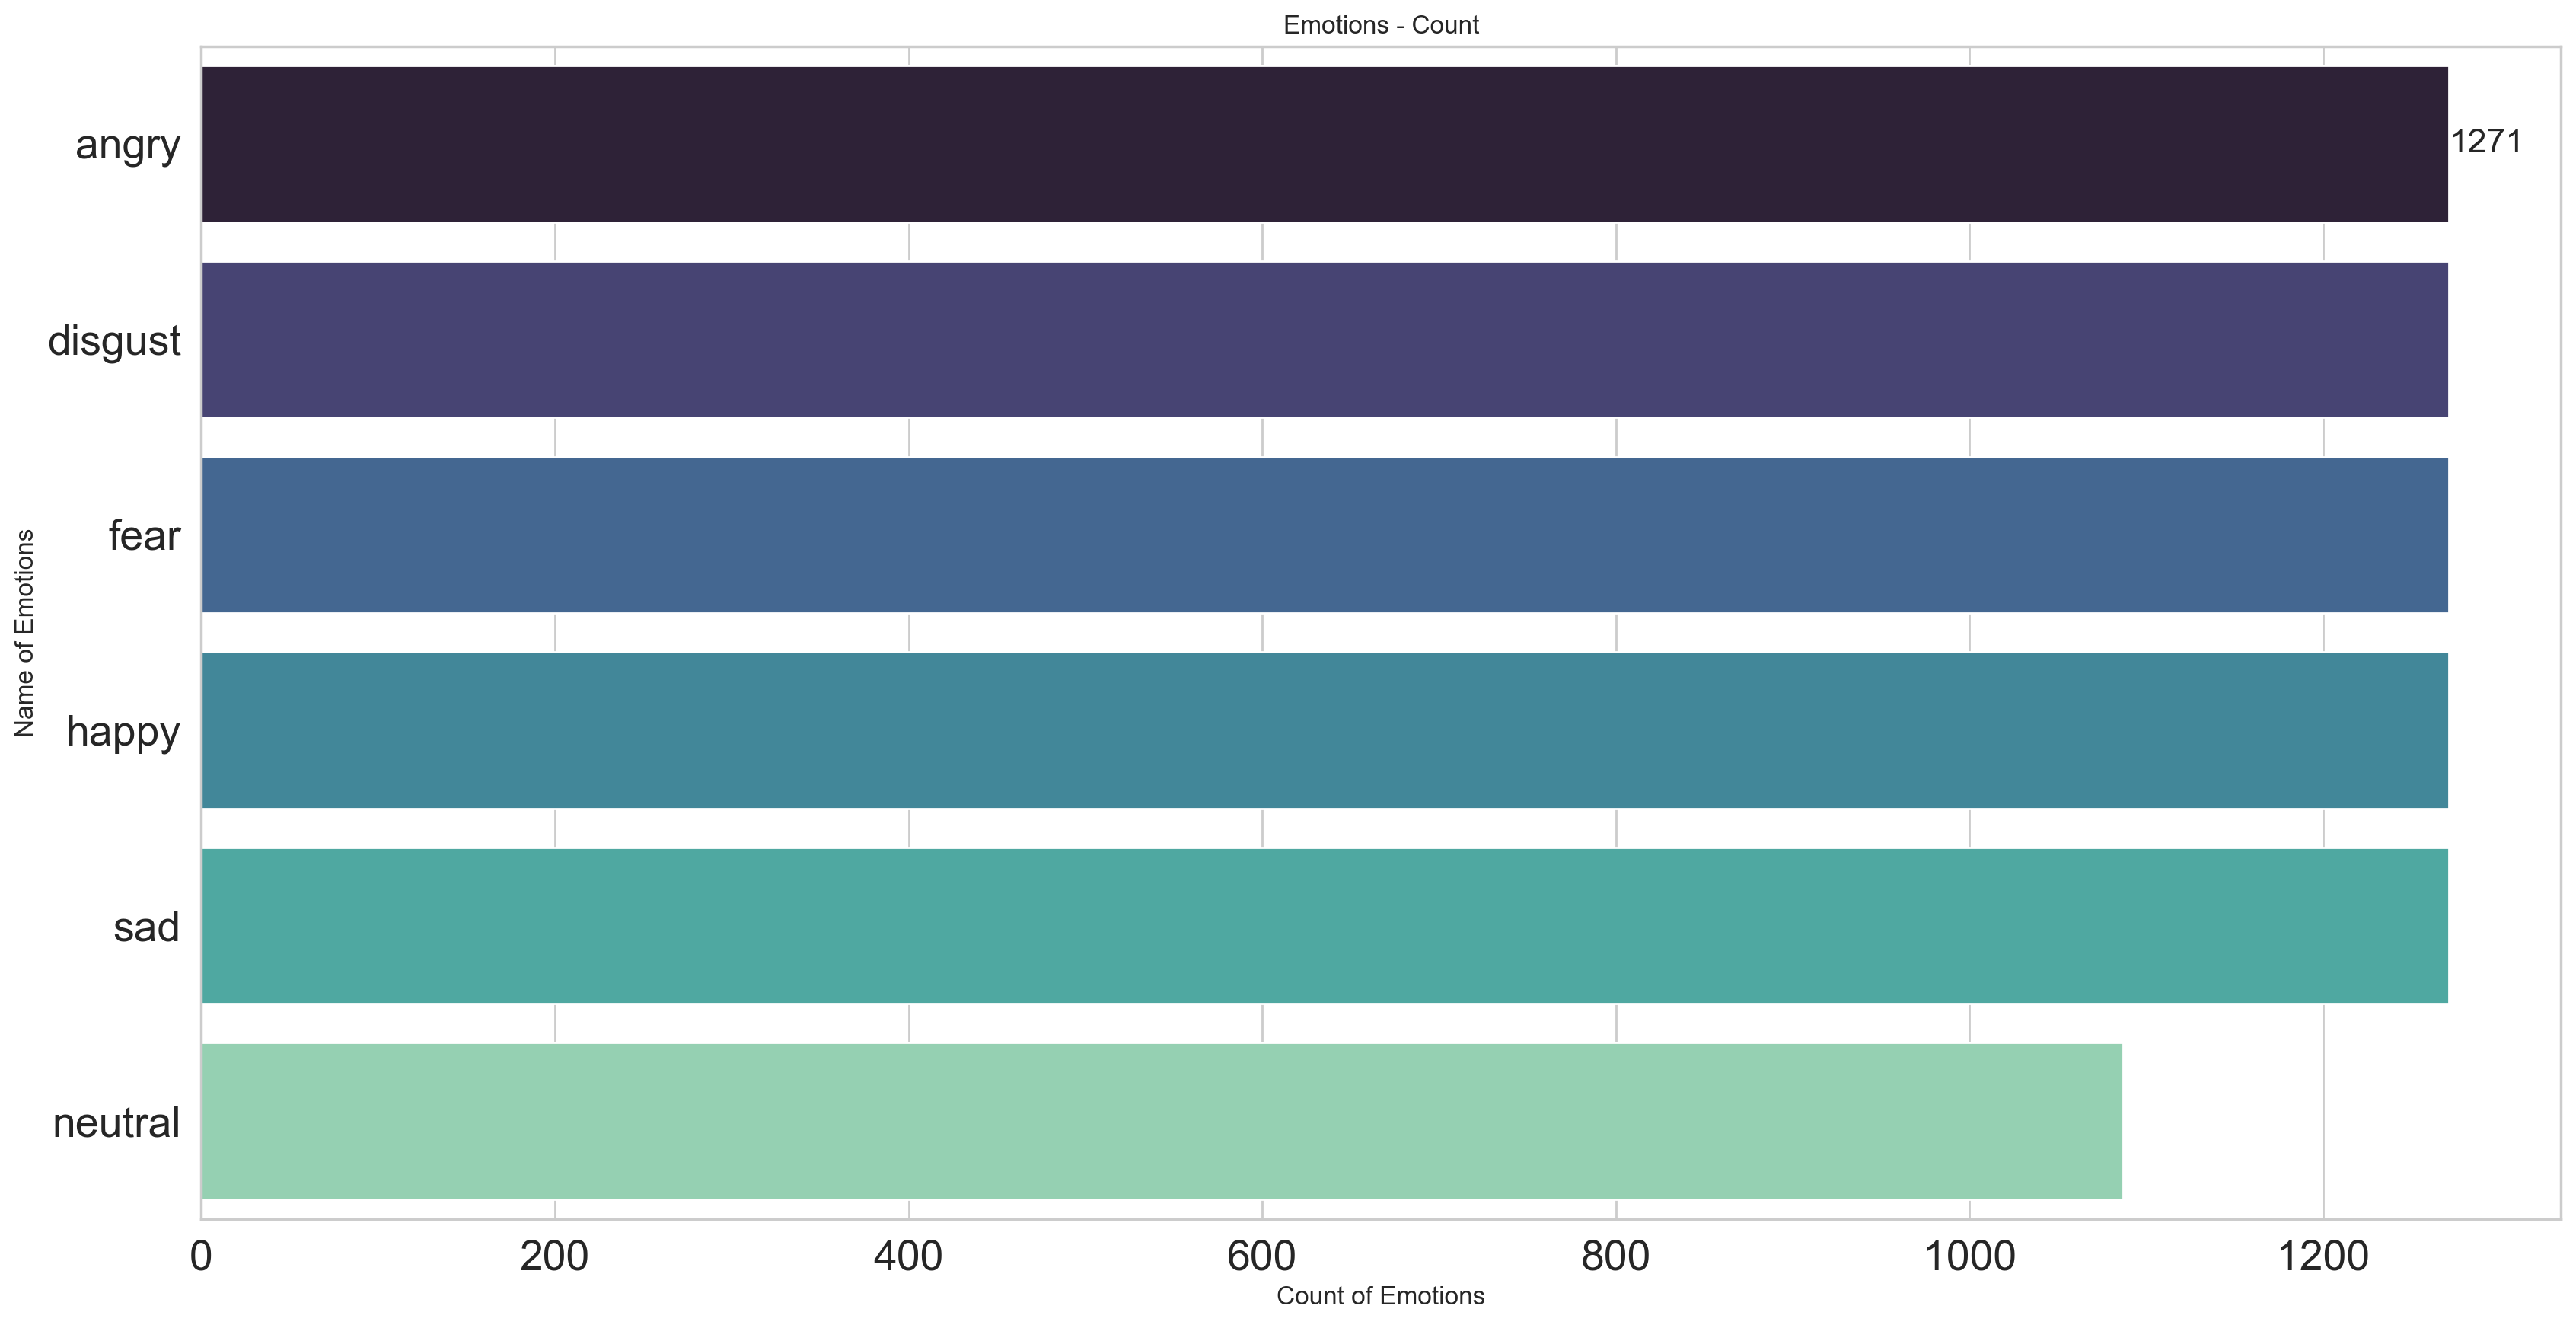

In [ ]:
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(20,10),dpi=200)
Count_emotion = features_df['label'].value_counts()[:]
ax = sns.barplot(x= Count_emotion, y= Count_emotion.index, palette="mako")
ax.bar_label(ax.containers[0],fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Name of Emotions")
plt.xlabel("Count of Emotions")
plt.title("Emotions - Count")
plt.show()

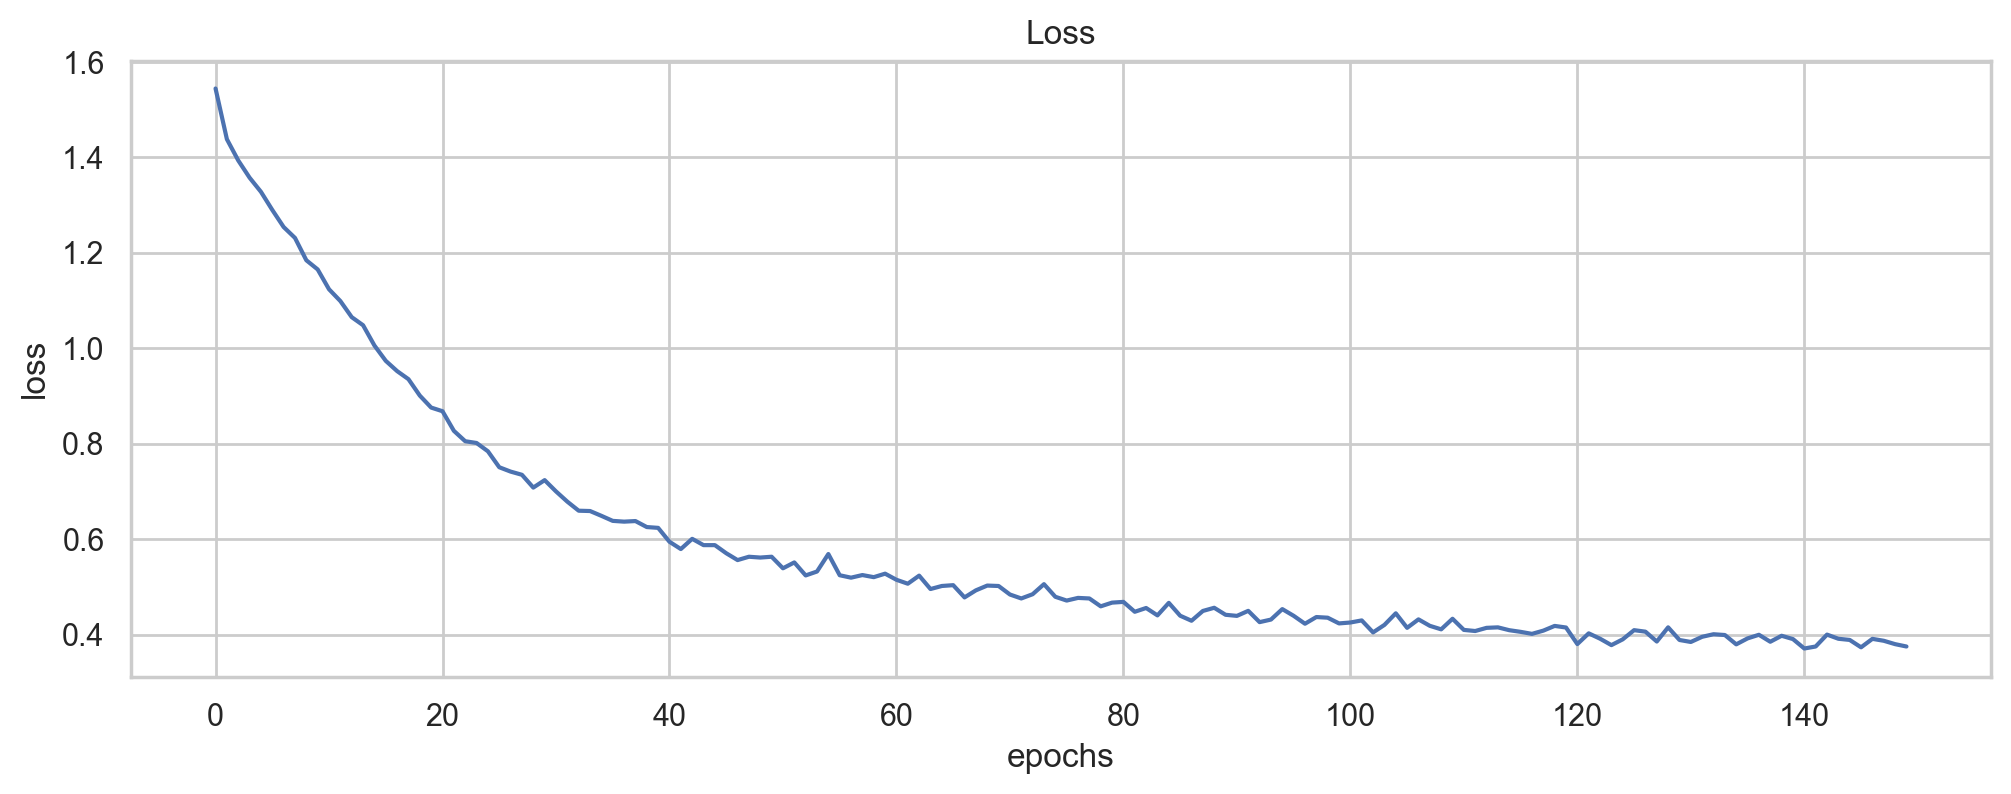

In [ ]:
loss = history.history['loss']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(epochs, loss, label='train loss', color='b')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss')
plt.show()

In [ ]:
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import os

# Fungsi untuk ekstraksi fitur
def extract_features(file_path, n_mfcc=40):
    audio, sample_rate = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    return mfccs_mean

# Direktori tempat file diekstrak
extraction_dir = 'crema_soundfile/'

# Membuat DataFrame untuk fitur dan label
features_list = []
labels_list = []

# Emosi yang ada dalam dataset
emotions = {
    'ANG': 'angry',
    'DIS': 'disgust',
    'FEA': 'fear',
    'HAP': 'happy',
    'NEU': 'neutral',
    'SAD': 'sad'
}

# Ekstraksi fitur dari setiap file dan menyimpannya dengan label yang sesuai
for file in os.listdir(extraction_dir):
    if file.endswith('.wav'):
        file_path = os.path.join(extraction_dir, file)
        emotion_code = file.split('_')[2]
        if emotion_code in emotions:
            features = extract_features(file_path)
            features_list.append(features)
            labels_list.append(emotions[emotion_code])

# Membuat DataFrame dengan fitur dan label
features_df = pd.DataFrame(features_list)
features_df['label'] = labels_list

# Membagi data menjadi train dan test
X = features_df.iloc[:, :-1].values
y = features_df['label'].values

# Encoding label
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Reshape data untuk LSTM
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(len(emotions), activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

checkpoint_filepath = 'best_model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1).numpy())

lr_scheduler_callback = LearningRateScheduler(scheduler)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=150, batch_size=64,
                    callbacks=[model_checkpoint_callback, lr_scheduler_callback])


c:\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,734 (1.17 MB)

 Trainable params: 305,734 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.1958 - loss: 1.7708
Epoch 1: val_accuracy improved from -inf to 0.26784, saving model to best_model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.1963 - loss: 1.7702 - val_accuracy: 0.2678 - val_loss: 1.6489 - learning_rate: 0.0010
Epoch 2/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2995 - loss: 1.6312
Epoch 2: val_accuracy improved from 0.26784 to 0.27792, saving model to best_model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.2995 - loss: 1.6312 - val_accuracy: 0.2779 - val_loss: 1.6546 - learning_rate: 0.0010
Epoch 3/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3147 - loss: 1.5957
Epoch 3: val_accuracy improved from 0.27792 to 0.36524, saving model to best_model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.3148 - loss: 1.5954 - val_accuracy: 0.3652 - val_loss: 1.5204 - learning_rate: 0.0010
Epoch 4/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accu

In [ ]:
# Evaluasi model pada data uji
lstm_loss, lstm_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f'LSTM Model Accuracy: {lstm_accuracy}')
print(f'LSTM Model Loss: {lstm_loss}')

LSTM Model Accuracy: 0.46877098083496094
LSTM Model Loss: 1.358019471168518


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Confusion Matrix:
[[170  13  11  30   9   2]
 [ 35  79  19  26  46  64]
 [ 22  14  73  20  38  72]
 [ 39  44  28  95  50   4]
 [  4  38  19  24 101  38]
 [  1  14  22   5  40 180]]


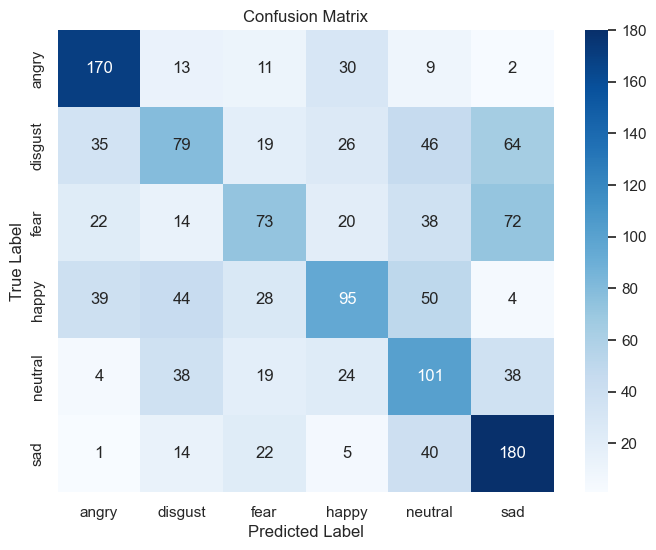

In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

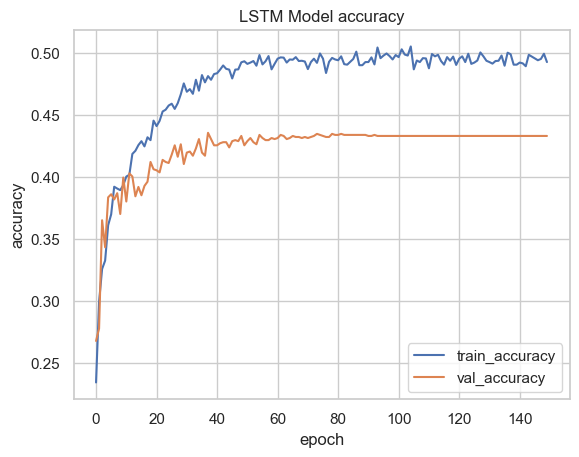

In [ ]:
plt. plot (history. history['accuracy'])
plt. plot(history.history[ 'val_accuracy'])
plt. title( 'LSTM Model accuracy')
plt. ylabel( 'accuracy')
plt. xlabel( 'epoch')
plt. legend(['train_accuracy', 'val_accuracy'])
plt. show()

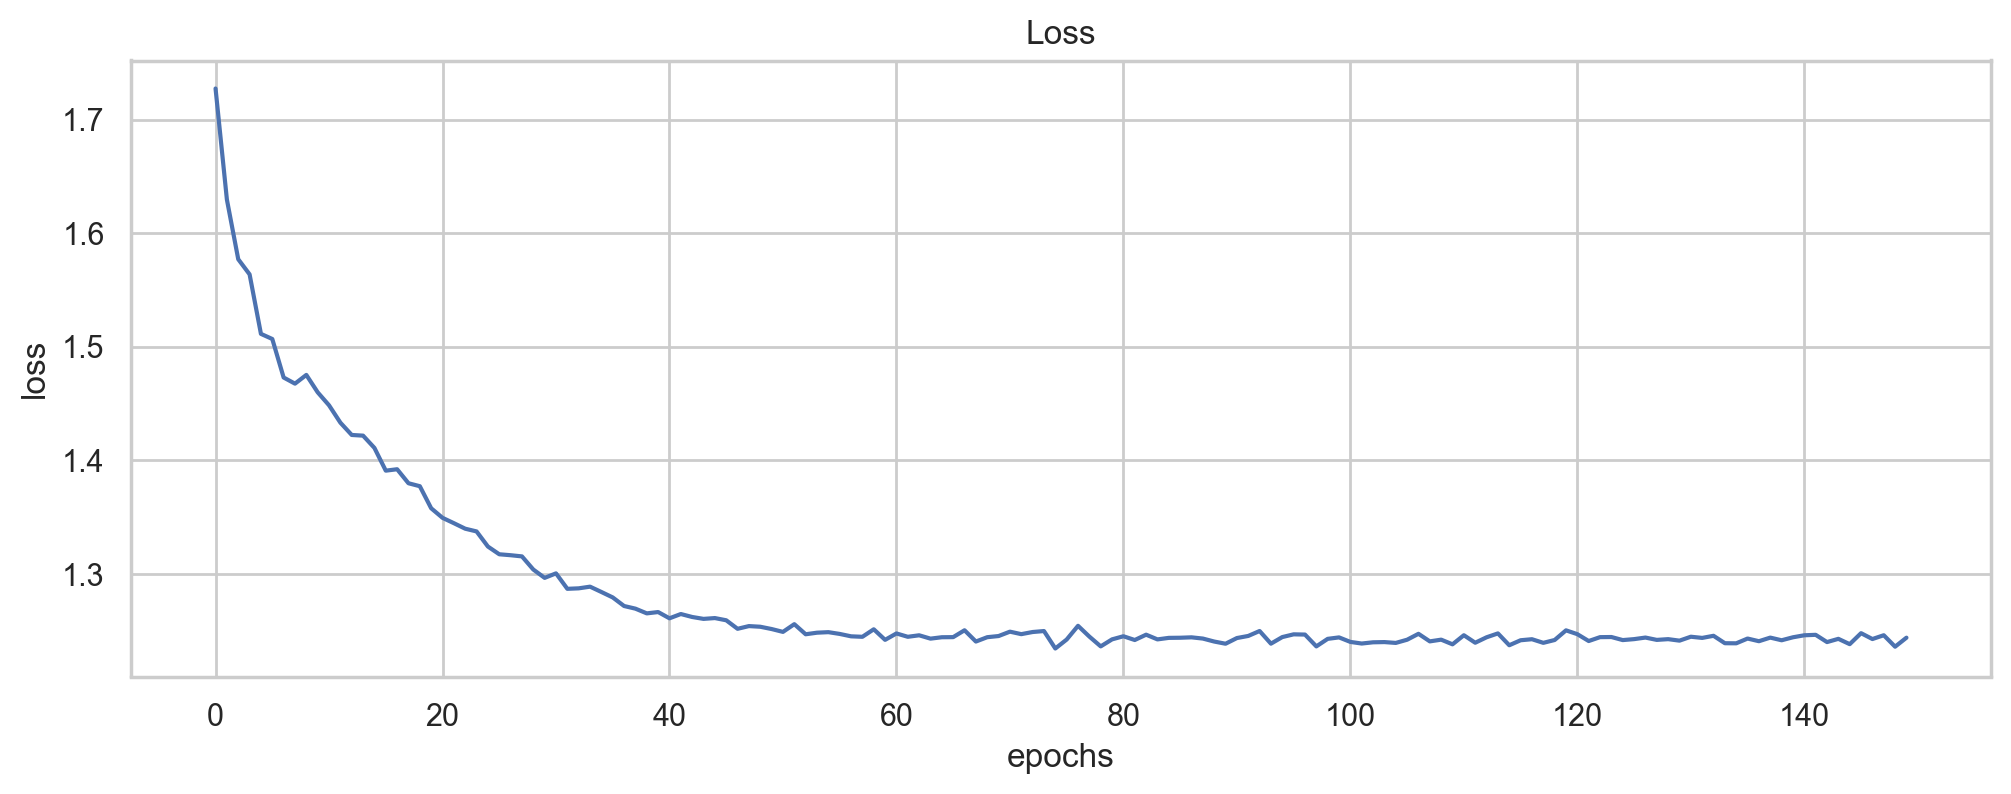

In [ ]:
loss = history.history['loss']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(epochs, loss, label='train loss', color='b')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss')
plt.show()